In [1]:
!pip install transformers datasets peft torch accelerate pillow bitsandbytes # bitsandbytes often needed for efficient loading

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:01m0:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 21.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nv

In [2]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Blip2ForConditionalGeneration, Blip2Processor, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType

2025-05-10 11:34:11.669601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746876851.867774      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746876851.920692      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class VQADataset(Dataset):
    def __init__(self, json_dirs, base_img_path, processor):
        self.samples = []
        self.processor = processor
        self.base_img_path = base_img_path

        print(f"📁 Scanning JSON folders: {json_dirs}")

        for dir_path in ([json_dirs] if isinstance(json_dirs, str) else json_dirs):
            for root, _, files in os.walk(dir_path):
                for file in files:
                    if file.endswith(".json"):
                        json_path = os.path.join(root, file)
                        with open(json_path, "r") as f:
                            data = json.load(f)

                        image_rel_path = data["image_path"].replace("\\", "/")

                        # Remove everything before and including 'abo-images-small/'
                        if "abo-images-small/" in image_rel_path:
                            image_rel_path = image_rel_path.split("abo-images-small/", 1)[1]

                        image_path = os.path.join(base_img_path, image_rel_path)

                        for qa in data["qa_pairs"]:
                            self.samples.append({
                                "image_path": image_path,
                                "question": qa["question"],
                                "answer": qa["answer"]
                            })

        print(f"✅ Loaded {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["image_path"]).convert("RGB")

        inputs = self.processor(
            images=image,
            text=sample["question"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )

        labels = self.processor.tokenizer(
            sample["answer"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=10
        ).input_ids

        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = labels.squeeze(0)

        # Remove inputs_embeds if it exists
        if "inputs_embeds" in inputs:
            del inputs["inputs_embeds"]

        return inputs

In [4]:
def compute_metrics(pred):
    preds = pred.predictions
    labels = pred.label_ids

    tokenizer = Blip2Processor.from_pretrained("Salesforce/blip-vqa-base").tokenizer
    pred_texts = tokenizer.batch_decode(preds, skip_special_tokens=True)
    label_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    correct = sum(p.strip().lower() == l.strip().lower() for p, l in zip(pred_texts, label_texts))
    acc = correct / len(label_texts)
    print(f"✅ Accuracy: {acc:.4f}")
    return {"accuracy": acc}

In [5]:
from transformers import BlipProcessor, BlipForQuestionAnswering, TrainingArguments, Trainer
import torch
from torch.utils.data import random_split
from datasets import load_dataset

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"

# Training cell 


In [7]:

torch.cuda.empty_cache()  # Clears unused memory from the cache

In [ ]:
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from peft import get_peft_model, LoraConfig, TaskType
# from torch.utils.data import DataLoader, random_split
# import torch
# from torch import optim
# import os
# import matplotlib.pyplot as plt
# import json

# # ---------- Setup ----------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load processor and base model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
# model.to(device)

# # Apply LoRA
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     target_modules=['qkv', 'projection'],
#     lora_dropout=0.05,
#     bias='none'
# )
# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()

# # ---------- Dataset Setup ----------
# json_root_dir = "/kaggle/input/master-train/master_train/batch_3"
# image_base_dir = "/kaggle/input/abo-dataset"
# dataset = VQADataset(json_dirs=json_root_dir, base_img_path=image_base_dir, processor=processor)

# # Split dataset
# split_ratio = 0.9
# train_size = int(split_ratio * len(dataset))
# eval_size = len(dataset) - train_size
# train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# eval_loader = DataLoader(eval_dataset, batch_size=8)



In [ ]:
# import os
# import torch
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # ---------- Optimizer ----------
# optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# # Save setup
# save_path = "/kaggle/working/model_latest"
# os.makedirs(save_path, exist_ok=True)
# save_every = 1000  # save every N steps

# # Resume state (optional)
# resume_state_path = os.path.join(save_path, "training_state.pt")
# start_step = 0
# loss_history = []

# if os.path.exists(resume_state_path):
#     print("🔁 Resuming training from checkpoint...")
#     checkpoint = torch.load(resume_state_path)
#     model.load_state_dict(checkpoint["model_state"])
#     optimizer.load_state_dict(checkpoint["optimizer_state"])
#     start_step = checkpoint["step"]
#     loss_history = checkpoint["loss_history"]

# # ---------- Training Loop ----------
# epochs = 1
# model.train()
# step_counter = start_step
# total_steps = len(train_loader) * epochs

# for epoch in range(epochs):
#     print(f"🔥 Epoch {epoch + 1}")
#     epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)
#     for batch in epoch_bar:
#         step_counter += 1

#         # Move inputs to device
#         inputs = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

#         # Forward pass
#         outputs = model(**inputs)
#         loss = outputs.loss

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Log loss
#         loss_history.append((step_counter, loss.item()))

#         # Progress update on tqdm bar
#         epoch_bar.set_postfix({
#             "Step": step_counter,
#             "Loss": f"{loss.item():.4f}",
#             "Progress": f"{(step_counter / total_steps) * 100:.2f}%"
#         })

#         # Save every N steps
#         if step_counter % save_every == 0:
#             print(f"💾 Saving at step {step_counter}...")
#             model.save_pretrained(save_path)
#             processor.save_pretrained(save_path)
#             torch.save({
#                 "model_state": model.state_dict(),
#                 "optimizer_state": optimizer.state_dict(),
#                 "step": step_counter,
#                 "loss_history": loss_history,
#             }, resume_state_path)

# # Final Save
# print("✅ Final save after training...")
# model.save_pretrained(save_path)
# processor.save_pretrained(save_path)
# torch.save({
#     "model_state": model.state_dict(),
#     "optimizer_state": optimizer.state_dict(),
#     "step": step_counter,
#     "loss_history": loss_history,
# }, resume_state_path)

# # ---------- Plot Loss ----------
# steps, losses = zip(*loss_history)
# plt.figure(figsize=(10, 5))
# plt.plot(steps, losses, label="Training Loss")
# plt.xlabel("Step")
# plt.ylabel("Loss")
# plt.title("Loss vs. Training Step")
# plt.grid(True)
# plt.legend()
# plt.savefig(os.path.join(save_path, "loss_plot.png"))
# plt.show()


# Batch -2 onwards training

In [10]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

# ---------- Setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Paths
load_path = "/kaggle/input/blip-finetunedmodel-versions/model_latest_v9" # Load from
save_path = "/kaggle/working/model_latest_v10"                # Save to
resume_state_path = os.path.join(save_path, "training_state.pt")

# Load processor and model from load_path
processor = BlipProcessor.from_pretrained(load_path)
model = BlipForQuestionAnswering.from_pretrained(load_path)

# Apply LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=['qkv', 'projection'],
    lora_dropout=0.05,
    bias='none'
)
model = get_peft_model(model, lora_config)
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=10e-5)

# Load checkpoint if available
if os.path.exists(resume_state_path):
    print("🔁 Loading checkpoint...")
    checkpoint = torch.load(resume_state_path)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_step = checkpoint["step"]
    loss_history = checkpoint["loss_history"]
else:
    print("🆕 Starting fresh training.")
    start_step = 0
    loss_history = []

# ---------- Dataset ----------
json_root_dir = "/kaggle/input/master-train/master_train/batch_10"
image_base_dir = "/kaggle/input/abo-dataset"
dataset = VQADataset(json_dirs=json_root_dir, base_img_path=image_base_dir, processor=processor)

# Split dataset
split_ratio = 0.9
train_size = int(split_ratio * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8)

# ---------- Training ----------
epochs = 1
save_every = 1000
step_counter = start_step
total_steps = len(train_loader) * epochs
model.train()

for epoch in range(epochs):
    print(f"\n🔥 Epoch {epoch + 1}/{epochs}")
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Training")
    for batch in pbar:
        step_counter += 1

        inputs = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        outputs = model(**inputs)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append((step_counter, loss.item()))

        pbar.set_postfix({"Step": step_counter, "Loss": f"{loss.item():.4f}"})

        # Periodic checkpoint saving
        if step_counter % save_every == 0:
            os.makedirs(save_path, exist_ok=True)
            model.save_pretrained(save_path)
            processor.save_pretrained(save_path)
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "step": step_counter,
                "loss_history": loss_history
            }, resume_state_path)

# ---------- Final Save ----------
print("✅ Final save after training.")
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
processor.save_pretrained(save_path)
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "step": step_counter,
    "loss_history": loss_history
}, resume_state_path)

# ---------- Loss Plot ----------
steps, losses = zip(*loss_history)
# Extract model name from save_path
model_name = os.path.basename(save_path)

# Plot 1: Raw Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"{model_name} - Training Loss vs. Steps")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_raw.png"))
plt.show()

# Plot 2: Smoothed Loss
smoothed_losses = gaussian_filter1d(losses, sigma=5)
plt.figure(figsize=(10, 5))
plt.plot(steps, smoothed_losses, label="Smoothed Training Loss", color='orange')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"{model_name} - Smoothed Loss vs. Steps")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_smoothed.png"))
plt.show()

# Plot 3: Log-Scale Loss
plt.figure(figsize=(10, 5))
plt.semilogy(steps, losses, label="Log-Scale Training Loss", color='green')
plt.xlabel("Step")
plt.ylabel("Loss (log scale)")
plt.title(f"{model_name} - Log-Scale Loss vs. Steps")
plt.grid(True, which='both')
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_logscale.png"))
plt.show()

KeyboardInterrupt: 

✅ Final save after training.


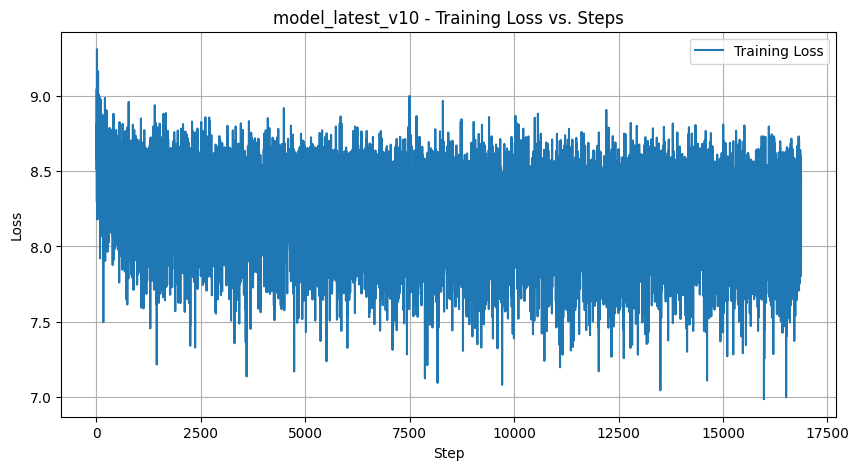

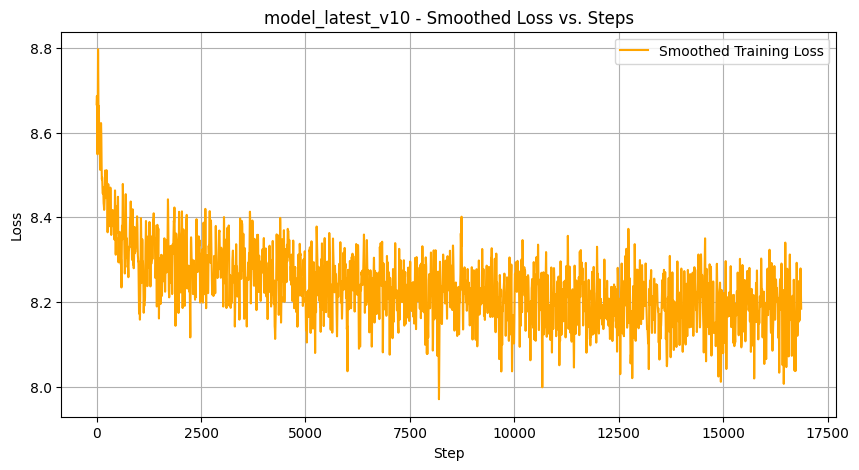

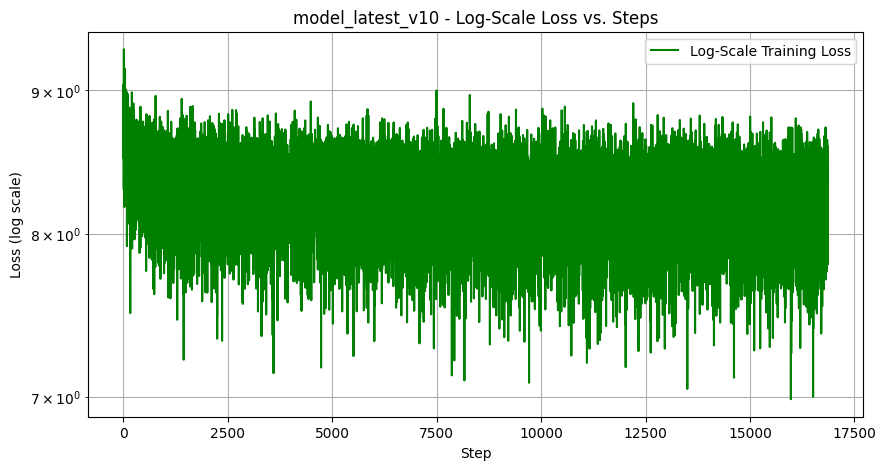

In [12]:
print("✅ Final save after training.")
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
processor.save_pretrained(save_path)
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "step": step_counter,
    "loss_history": loss_history
}, resume_state_path)

steps, losses = zip(*loss_history)
# Extract model name from save_path
model_name = os.path.basename(save_path)

# Plot 1: Raw Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"{model_name} - Training Loss vs. Steps")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_raw.png"))
plt.show()

# Plot 2: Smoothed Loss
smoothed_losses = gaussian_filter1d(losses, sigma=5)
plt.figure(figsize=(10, 5))
plt.plot(steps, smoothed_losses, label="Smoothed Training Loss", color='orange')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"{model_name} - Smoothed Loss vs. Steps")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_smoothed.png"))
plt.show()

# Plot 3: Log-Scale Loss
plt.figure(figsize=(10, 5))
plt.semilogy(steps, losses, label="Log-Scale Training Loss", color='green')
plt.xlabel("Step")
plt.ylabel("Loss (log scale)")
plt.title(f"{model_name} - Log-Scale Loss vs. Steps")
plt.grid(True, which='both')
plt.legend()
plt.savefig(os.path.join(save_path, "loss_plot_logscale.png"))
plt.show()

In [13]:
import shutil
# Compress folder into a zip file
shutil.make_archive('/kaggle/working/model_latest_v10', 'zip', '/kaggle/working/model_latest_v10')

'/kaggle/working/model_latest_v10.zip'

In [14]:
!pip install bert-score
!pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Testing cell 


In [15]:
import os
import torch
from torch.amp import autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BlipProcessor, BlipForQuestionAnswering
from accelerate import Accelerator
import time
from sklearn.metrics import f1_score
from bert_score import score as bert_score_fn

# Step 1: Set environment variable to disable tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Initialize Accelerator
accelerator = Accelerator()
device = accelerator.device

# Load model and processor
load_path = "/kaggle/working/model_latest_v10"
model = BlipForQuestionAnswering.from_pretrained(load_path)
processor = BlipProcessor.from_pretrained(load_path)

# Prepare model for distributed inference
model = accelerator.prepare(model)

# Load dataset
test_json_dir = "/kaggle/input/master-test/test_dataset"
test_image_dir = "/kaggle/input/abo-dataset"
test_dataset = VQADataset(
    json_dirs=test_json_dir,
    base_img_path=test_image_dir,
    processor=processor
)

# DataLoader setup
batch_size = 100
num_workers = 14
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

# Evaluation setup
model.eval()
correct = 0
total = 0
batch_count = len(test_loader)

predicted_all = []
true_all = []

start_time = time.time()

# Evaluation loop
with torch.no_grad():
    for batch in tqdm(test_loader, total=batch_count, desc="Evaluating"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        answers = batch["labels"]

        with autocast(device_type=device.type, dtype=torch.float16):
            generated_ids = model.generate(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                max_length=20,
                do_sample=False,
                num_beams=1
            )

        predicted_answers = processor.batch_decode(generated_ids, skip_special_tokens=True)
        decoded_answers = [
            processor.tokenizer.decode(ans, skip_special_tokens=True)
            if isinstance(ans, torch.Tensor) else ans
            for ans in answers
        ]

        for pred, true_ans_str in zip(predicted_answers, decoded_answers):
            pred_clean = pred.strip().lower()
            true_clean = true_ans_str.strip().lower()

            predicted_all.append(pred_clean)
            true_all.append(true_clean)

            if pred_clean == true_clean:
                correct += 1
            total += 1

end_time = time.time()
elapsed = end_time - start_time

# Compute Exact Match
exact_match = 100 * correct / total

# Compute BERTScore
P, R, F1 = bert_score_fn(predicted_all, true_all, lang="en", verbose=True)
bert_score_f1 = F1.mean().item()
bert_score_precision = P.mean().item()
bert_score_recall = R.mean().item()

# Print all metrics
print(f"\n📊 Evaluation Metrics:")
print(f"✅ Exact Match (EM): {exact_match:.2f}%")
print(f"🤖 BERTScore - Precision: {bert_score_precision:.4f}")
print(f"🤖 BERTScore - Recall:    {bert_score_recall:.4f}")
print(f"🤖 BERTScore - F1:        {bert_score_f1:.4f}")
print(f"\n⏱️ Total Evaluation Time: {elapsed:.2f} seconds for {total} samples.")
print(f"⚡ Inference Speed: {total / elapsed:.2f} it/sec")

📁 Scanning JSON folders: /kaggle/input/master-test/test_dataset


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Loaded 482036 samples.


Evaluating: 100%|██████████| 4821/4821 [4:29:32<00:00,  3.35s/it]  


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/432 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7532 [00:00<?, ?it/s]

done in 96.70 seconds, 4985.06 sentences/sec

📊 Evaluation Metrics:
✅ Exact Match (EM): 19.94%
🤖 BERTScore - Precision: 0.9555
🤖 BERTScore - Recall:    0.9365
🤖 BERTScore - F1:        0.9450

⏱️ Total Evaluation Time: 16172.37 seconds for 482036 samples.
⚡ Inference Speed: 29.81 it/sec


In [16]:
print(f"✅ Exact Match (EM): {exact_match:.2f}%") 

✅ Exact Match (EM): 19.94%


In [17]:
print(f"🤖 BERTScore - Precision: {bert_score_precision:.4f}")
print(f"🤖 BERTScore - Recall:    {bert_score_recall:.4f}")
print(f"🤖 BERTScore - F1:        {bert_score_f1:.4f}")

🤖 BERTScore - Precision: 0.9555
🤖 BERTScore - Recall:    0.9365
🤖 BERTScore - F1:        0.9450


In [18]:
print(f"\n⏱️ Total Evaluation Time: {elapsed:.2f} seconds for {total} samples.")
print(f"⚡ Inference Speed: {total / elapsed:.2f} it/sec")


⏱️ Total Evaluation Time: 16172.37 seconds for 482036 samples.
⚡ Inference Speed: 29.81 it/sec
